In [82]:
import torch
import diffusers
import transformers
from PIL import Image

In [83]:
def get_device_and_dtype():
    if torch.cuda.is_available():
        device = "cuda:0"
        dtype = torch.float16
    else:
        device = "cpu"
        dtype = torch.float32
    print(f"Using device: {device} and dtype: {dtype}")
    return device, dtype

In [84]:
# Load models (same names-
def load_models(model_id: str, device: str, dtype: torch.dtype):
    tokenizer = transformers.CLIPTokenizer.from_pretrained(
        model_id, subfolder="tokenizer"
    )

    embedder = transformers.CLIPTextModel.from_pretrained(
        model_id, subfolder="text_encoder", torch_dtype=dtype
    ).to(device).eval()

    vae = diffusers.AutoencoderKL.from_pretrained(
        model_id, subfolder="vae", torch_dtype=dtype
    ).to(device).eval()


    unet = diffusers.UNet2DConditionModel.from_pretrained(
        model_id, subfolder="unet", torch_dtype=dtype, low_cpu_mem_usage=True
    ).to(device).eval()

    scheduler = diffusers.UniPCMultistepScheduler.from_pretrained(
        model_id, subfolder="scheduler"
    )

    return tokenizer, embedder, vae, unet, scheduler

In [85]:
# Prompt -> all_embeddings
@torch.no_grad()
def get_all_embeddings(prompt, tokenizer, embedder, device, negative_prompt=""):
    # conditioned tokens/embedding
    text_tokens = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    text_embedding = embedder(text_tokens.input_ids.to(device)).last_hidden_state

    # unconditioned tokens/embedding
    uncond_tokens = tokenizer(
        negative_prompt,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    uncond_embedding = embedder(uncond_tokens.input_ids.to(device)).last_hidden_state

    # concat for CFG: (2, 77, 768)
    all_embeddings = torch.cat([uncond_embedding, text_embedding], dim=0)
    return all_embeddings

In [86]:
# Create random latents (same names)
def get_random_latents(vae, scheduler, device, dtype, height=512, width=512, batch_size=1, scale_factor=8):
    if height % scale_factor != 0 or width % scale_factor != 0:
        raise ValueError("height and width must be divisible by 8.")

    latent_channels = vae.config.latent_channels  # usually 4

    latent_shape = (
        batch_size,
        latent_channels,
        height // scale_factor,
        width // scale_factor,
    )

    random_latents = torch.randn(latent_shape, device=device, dtype=dtype)

    # scale initial noise to match scheduler expectations
    latents = random_latents * scheduler.init_noise_sigma
    return latents



In [87]:
# Denoising loop (CFG correct)
@torch.no_grad()
def denoise_latents(latents, unet, scheduler, all_embeddings, guidance_scale=7.5, num_steps=30):
    scheduler.set_timesteps(num_steps)

    for t in scheduler.timesteps:
        # duplicate latents for [uncond, cond]
        latents_inputs = torch.cat([latents, latents], dim=0)
        latents_inputs = scheduler.scale_model_input(latents_inputs, timestep=t)

        # predict noise residual
        noise_pred = unet(
            latents_inputs,
            t,
            encoder_hidden_states=all_embeddings
        ).sample

        # split unconditional and conditional predictions
        noise_uncond, noise_cond = noise_pred.chunk(2)

        # CFG formula (correct)
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

        # update latents
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents


In [88]:
# Latents -> PIL image
@torch.no_grad()
def latents_to_image(latents, vae):
    decoded = vae.decode(latents / vae.config.scaling_factor).sample  # (1,3,H,W)
    unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()              # (1,H,W,3)
    scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")
    return Image.fromarray(scaled[0])


In [89]:
# One wrapper
def generate_image_from_prompt(
    prompt: str,
    model_id="CompVis/stable-diffusion-v1-4",
    negative_prompt="",
    height=512,
    width=512,
    batch_size=1,
    scale_factor=8,
    guidance_scale=7.5,
    num_steps=30
):
    device, dtype = get_device_and_dtype()
    tokenizer, embedder, vae, unet, scheduler = load_models(model_id, device, dtype)

    all_embeddings = get_all_embeddings(prompt, tokenizer, embedder, device, negative_prompt=negative_prompt)
    latents = get_random_latents(vae, scheduler, device, dtype, height=height, width=width,
                                 batch_size=batch_size, scale_factor=scale_factor)
    latents = denoise_latents(latents, unet, scheduler, all_embeddings,
                              guidance_scale=guidance_scale, num_steps=num_steps)
    image = latents_to_image(latents, vae)
    return image

Using device: cpu and dtype: torch.float32


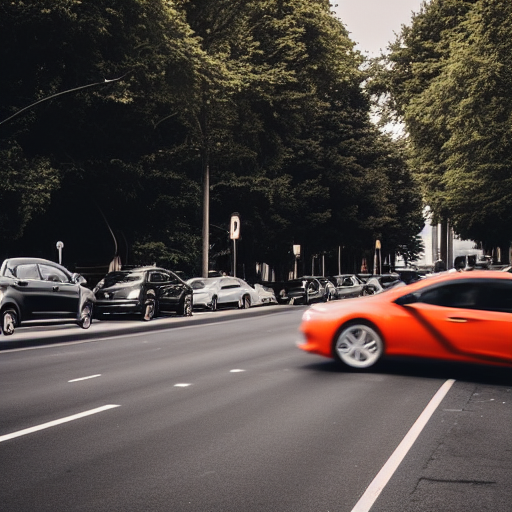

In [90]:
generate_image_from_prompt(
    prompt="A black car in traffic",
    model_id="CompVis/stable-diffusion-v1-4",
    negative_prompt="",
    height=512,
    width=512,
    batch_size=1,
    scale_factor=8,
    guidance_scale=7.5,
    num_steps=30
)